In [65]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

import scipy.io as sio
slim = tf.contrib.slim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
from nets import txtbox_300
from skimage.transform import resize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from nets import txtbox_300, textbox_common, np_methods
from processing import txt_preprocessing
from processing import visualization
# another v

In [67]:
isess = tf.InteractiveSession()

In [69]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.

image_pre, labels_pre, bboxes_pre, bbox_img, num = txt_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=txt_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'net' in locals() else None
net = txtbox_300.TextboxNet()
#anchors = net.anchors(net_shape)
with slim.arg_scope(net.arg_scope(data_format=data_format)):
    localisations, predictions,  _ = net.net(image_4d, is_training=False, reuse=True,use_batch=True)
    #localisations, predictions = net.bboxes_encode(bboxes_pre, anchors, 3,match_threshold = 0.5)
    for i in range(len(predictions)):
        predictions[i] = tf.nn.softmax(predictions[i])
        


{'global': <tf.Tensor 'text_box_300_2/global/conv3x3/Relu:0' shape=(1, 1, 1, 256) dtype=float32>, 'conv3': <tf.Tensor 'text_box_300_2/conv3/conv3_3/Relu:0' shape=(1, 75, 75, 256) dtype=float32>, 'conv2': <tf.Tensor 'text_box_300_2/conv2/conv2_2/Relu:0' shape=(1, 150, 150, 128) dtype=float32>, 'conv1': <tf.Tensor 'text_box_300_2/conv1/conv1_2/Relu:0' shape=(1, 300, 300, 64) dtype=float32>, 'conv10': <tf.Tensor 'text_box_300_2/conv10/conv3x3/Relu:0' shape=(1, 3, 3, 256) dtype=float32>, 'conv7': <tf.Tensor 'text_box_300_2/conv7/Relu:0' shape=(1, 19, 19, 1024) dtype=float32>, 'conv6': <tf.Tensor 'text_box_300_2/conv6/Relu:0' shape=(1, 19, 19, 1024) dtype=float32>, 'conv5': <tf.Tensor 'text_box_300_2/conv5/conv5_3/Relu:0' shape=(1, 19, 19, 512) dtype=float32>, 'conv4': <tf.Tensor 'text_box_300_2/conv4/conv4_3/Relu:0' shape=(1, 38, 38, 512) dtype=float32>, 'conv9': <tf.Tensor 'text_box_300_2/conv9/conv3x3/Relu:0' shape=(1, 5, 5, 256) dtype=float32>, 'conv8': <tf.Tensor 'text_box_300_2/conv8/

In [105]:
import tensorflow as tf
sess = tf.Session()
tf.contrib.framework.list_variables('../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt')


[('global_step', []),
 ('ssd_300_vgg/block10/conv1x1/biases', [128]),
 ('ssd_300_vgg/block10/conv1x1/weights', [1, 1, 256, 128]),
 ('ssd_300_vgg/block10/conv3x3/biases', [256]),
 ('ssd_300_vgg/block10/conv3x3/weights', [3, 3, 128, 256]),
 ('ssd_300_vgg/block10_box/conv_cls/biases', [84]),
 ('ssd_300_vgg/block10_box/conv_cls/weights', [3, 3, 256, 84]),
 ('ssd_300_vgg/block10_box/conv_loc/biases', [16]),
 ('ssd_300_vgg/block10_box/conv_loc/weights', [3, 3, 256, 16]),
 ('ssd_300_vgg/block11/conv1x1/biases', [128]),
 ('ssd_300_vgg/block11/conv1x1/weights', [1, 1, 256, 128]),
 ('ssd_300_vgg/block11/conv3x3/biases', [256]),
 ('ssd_300_vgg/block11/conv3x3/weights', [3, 3, 128, 256]),
 ('ssd_300_vgg/block11_box/conv_cls/biases', [84]),
 ('ssd_300_vgg/block11_box/conv_cls/weights', [3, 3, 256, 84]),
 ('ssd_300_vgg/block11_box/conv_loc/biases', [16]),
 ('ssd_300_vgg/block11_box/conv_loc/weights', [3, 3, 256, 16]),
 ('ssd_300_vgg/block4_box/L2Normalization/gamma', [512]),
 ('ssd_300_vgg/block4_bo

In [101]:
# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-1337.meta'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver = tf.train.import_meta_graph(ckpt_filename)
saver.restore(isess, '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt')

# SSD default anchor boxes.
anchors = net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt


NotFoundError: Key text_box_300/conv1/conv1_1/biases not found in checkpoint
	 [[Node: save_5/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_5/Const_0, save_5/RestoreV2/tensor_names, save_5/RestoreV2/shape_and_slices)]]

Caused by op u'save_5/RestoreV2', defined at:
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-101-37d7685f014e>", line 5, in <module>
    saver = tf.train.Saver()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Applications/python/anaconda/envs/tensorflow2.7/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key text_box_300/conv1/conv1_1/biases not found in checkpoint
	 [[Node: save_5/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_5/Const_0, save_5/RestoreV2/tensor_names, save_5/RestoreV2/shape_and_slices)]]


In [82]:
# Main image processing routine.
def process_image(img, select_threshold=0.51, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d,predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=2, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=1000)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    #rbboxes,rclasses, rscores = np_methods.non_max_suppression_fast(rclasses, rscores,rbboxes, nms_threshold)
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes,rimg

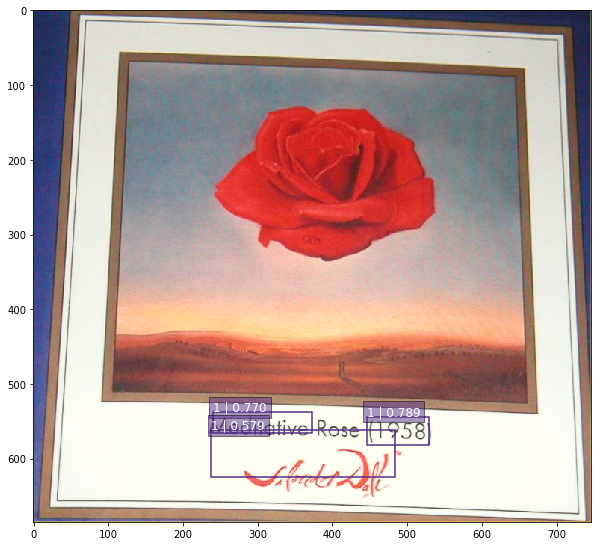

In [100]:
img = mpimg.imread('../data/ICDAR2013/ICDAR-Test-Images/img_209.jpg')
#img = resize(img, [700,700],mode='wrap',preserve_range=True)
rclasses, rscores, rbboxes,rimg =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [ ]:
rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d,predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
#rpredictions

In [ ]:
for i in range(6):
    print rlocalisations[i][np.where(rpredictions[i][:,:,:,:,:,1:] > 0.99)].shape

In [ ]:
rimg.shape

In [ ]:
#rpredictions.shape
loss = isess.run(tf.nn.softmax(tf.constant([[0.52,0.47],[-0.52,-0.47]])))
logit_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = tf.constant([[0.52,0.47],[-0.52,-0.47]]),
                                                         labels =tf.constant([0,1]) )
print isess.run([logit_loss])
print loss
print isess.run(tf.reduce_mean(logit_loss))

In [ ]:
l1 = tf.losses.compute_weighted_loss(logit_loss, tf.constant([1.0,0.]))
isess.run([l1])

In [ ]:
l_loss = tf.reduce_sum(logit_loss *  tf.constant([[1.0],[0.]])/1.0)
isess.run([l_loss])
logit_loss *  tf.constant([1.0,0.])